In [679]:
import requests, time
from bs4 import BeautifulSoup as bs, SoupStrainer as ss 
import pandas as pd, numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [680]:
prunes = ['Ancient_Greek','International_Phonetic_Alphabet','Greek_language','Help:IPA_for_Greek']
plumbs = ['Help:', 'Talk:']
loop = ['Philosophy','Education','Learning','Knowledge','Awareness','Quality_(philosophy)']
loopies = ['Lyndon_LaRouche','LaRouche_movement', 'World_War_II','Allies_of_World_War_II','Declaration_by_United_Nations'] 

# Set-up

In [681]:
def all_links(page):
    '''
    Given a page, return a list of all the hrefs appearing
    on the page 
    
    Returns: list(str):  
    '''
    
    url = 'https://en.wikipedia.org/wiki/%s' %page
    r = requests.get(url)
    main_div = ss('div', {'id': 'mw-content-text'})
    soup = bs(r.text,'lxml', parse_only=main_div)
    
    ps = soup.find_all('p')
    links = [a['href'] for p in ps for a in p.find_all('a')]
    refs = [link[6:] for link in links if link[:6]=='/wiki/']
    good_refs = [ref for ref in refs if ref not in prunes 
                             and ':' not in ref 
                             and 'disambiguation' not in ref]
    return good_refs

# Equals method

In [682]:
def equals(list_one, list_two):
    ''' Compares two lists based on the default equality of their indexes, given their lengths are equal'''
    equals = True 
    for i in range(0, len(list_one)):
        if (cmp(list_one[i], list_two[i]) == 0):
            equals = True
        else:
            equals = False
    return equals

# Create the dictionary

In [683]:
#n_iterations = 3

# create dictionary!!!!
#d = {}

#for i in xrange(n_iterations):
    #page = 'Special:Random'
    #url = 'https://en.wikipedia.org/wiki/%s' %page
    #r = requests.get(url)

    # find title
    #title_soup = bs(r.text,'lxml')
    #title = title_soup.find('link', rel='canonical')['href'][30:]

    # find all links
    #main_div = ss('div', {'id': 'mw-content-text'})
    #soup = bs(r.text,'lxml', parse_only=main_div)
    #ps = soup.find_all('p')
    #links = [a['href'] for p in ps for a in p.find_all('a')]
    #refs = [link[6:] for link in links if link[:6]=='/wiki/']
    #good_refs = [ref for ref in refs if ref not in prunes 
                             #and ':' not in ref 
                             #and 'disambiguation' not in ref]
    
    #d[title] = good_refs

In [684]:
data = []

In [686]:
# create dictionary!!!!
d = {}

page = 'Special:Random'
url = 'https://en.wikipedia.org/wiki/%s' %page
r = requests.get(url)

# find title
title_soup = bs(r.text,'lxml')
title_main = title_soup.find('link', rel='canonical')['href'][30:]
title_main

# find all links
main_div = ss('div', {'id': 'mw-content-text'})
soup = bs(r.text,'lxml', parse_only=main_div)
ps = soup.find_all('p')
links = [a['href'] for p in ps for a in p.find_all('a')]
refs = [link[6:] for link in links if link[:6]=='/wiki/']
parents = [ref for ref in refs if ref not in prunes 
                         and ':' not in ref 
                         and 'disambiguation' not in ref]

for parent in parents:

    url = 'https://en.wikipedia.org/wiki/%s' %parent
    r = requests.get(url)

    # find title
    title_soup = bs(r.text,'lxml')
    title = title_soup.find('link', rel='canonical')['href'][30:]

    # find all links
    main_div = ss('div', {'id': 'mw-content-text'})
    soup = bs(r.text,'lxml', parse_only=main_div)
    ps = soup.find_all('p')
    links = [a['href'] for p in ps for a in p.find_all('a')]
    refs = [link[6:] for link in links if link[:6]=='/wiki/']
    good_refs = [ref for ref in refs if ref not in prunes 
                             and ':' not in ref 
                             and 'disambiguation' not in ref]

    d[title] = good_refs

In [687]:
print title_main

Mocha_Island


In [688]:
data.append( (title_main,d) )

# Create the graph

In [689]:
def make_a_graph(some_dictionary):   
    G = nx.DiGraph()
    node_s = some_dictionary.keys()

    for key in some_dictionary.keys():
        node_s += some_dictionary[key]

    G.add_nodes_from(node_s)
    edges = []

    for key in some_dictionary.keys():
        children = some_dictionary[key]
        for child in children:
            edges.append( (key,child) )

    G.add_edges_from(edges)
    pr = nx.pagerank(G,alpha=0.8)
    pr_list = []
    for key in pr.keys():
        data_tuple = (key, pr[key])
        pr_list.append(data_tuple)
    return G

# Gets list of website names

In [690]:
def make_a_list(some_graph,some_alpha):
    pr = nx.pagerank(some_graph,alpha=some_alpha)
    pr_list = []
    for key in pr.keys():
        data_tuple = (key, pr[key])
        pr_list.append(data_tuple)
        
    websites = sorted(pr_list, key=lambda x: x[1], reverse=True)
    names = [x[0] for x in websites]  
    return names

# Mean squared error as method of determing difference

In [691]:
def mean_squared_error(some_graph, alpha_1, alpha_2):
    '''square root of mean squared error'''
    '''Graph, two different alphas,'''
    '''list_one = nx.pagerank(G, ALPHA1)
       list_two = nx.pagerank(G, ALPHA2)
       dictionary -> sorted list
       iterate through each node, compute diff(index1, index2)
       compute mean squared error'''
    list_one = make_a_list(some_graph,alpha_1)
    list_two = make_a_list(some_graph,alpha_2)
    sumN = 0
    list_diff = []
    list_1 = []
    list_2 = []
    equal = True
    for node in some_graph.nodes_iter():
        list_diff.append(list_one.index(node) - list_two.index(node))
    for el in range(0, len(list_diff)):
        sumN += list_diff[el] ** 2
    return (np.sqrt(sumN) / G.number_of_nodes())

In [693]:
print mean_squared_error(make_a_graph(d), .6, .1)

8189.98253966


# Making graphs

In [ ]:
entry = data[0]
#names = entry[0]
d = entry[1]

edges = []
for key in d.keys():
    links = d[key]
    for link in links:
        edge = (key, link)
        edges.append(edge)
        
G = nx.DiGraph(edges)

In [ ]:
len(G.nodes())

In [ ]:
for alpha in [0.1*(x+1) for x in range(9)]:
    nx.pagerank(G, alpha=alpha)

In [ ]:
nx.write_graphml(G, 'test_graph.graphml')

In [ ]:
nx.draw(G)

# Making random graphs

In [ ]:
# Erdos-Renyi

In [ ]:
n = 10
p = .8
er_G = nx.fast_gnp_random_graph(n, p, directed=True)

In [ ]:
nx.draw(er_G)

In [694]:
# construct a dataframe to store our data
res = 20 # the resolution
df_ER = pd.DataFrame(columns=range(res-1))
df_ER

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18


In [695]:
n_iterations = 10
n_nodes = 50
p_create_edge = 0.5
for __ in xrange(n_iterations):
    er_G = nx.fast_gnp_random_graph(n=n_nodes, p=p_create_edge, directed=True)
    alpha_one = 0
    errors = []
    for alpha in [(1.0/res)*(x+1) for x in range(res-1)]:
        pr_next = nx.pagerank(er_G, alpha=alpha) # compute new page rank
        
        # compute MSE
        error = mean_squared_error(er_G, alpha_one, alpha)
        errors.append(error)
        
        alpha_one = alpha # prepare for next iteration
    new_row = pd.Series(errors)
    df_ER = df_ER.append(new_row, ignore_index=True)

In [696]:
df_ER

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,69.148391,1.000000,1.870829,1.224745,1.224745,1.414214,1.224745,1.224745,1.224745,1.000000,1.414214,2.121320,1.000000,0.000000,1.224745,0.707107,1.414214,1.414214,1.224745
1,69.903505,1.414214,1.000000,0.000000,1.224745,1.000000,1.224745,0.707107,1.224745,1.000000,1.000000,1.224745,1.732051,1.581139,1.414214,0.000000,1.000000,1.000000,0.707107
2,72.242647,1.000000,1.000000,2.345208,1.224745,1.000000,1.000000,1.581139,1.870829,2.000000,1.224745,1.224745,1.224745,1.414214,2.345208,1.000000,1.000000,0.707107,1.224745
3,64.027338,0.000000,1.224745,1.732051,1.870829,1.000000,1.224745,1.224745,0.000000,1.224745,1.414214,0.000000,1.414214,0.000000,1.000000,1.224745,1.581139,1.000000,0.707107
4,59.506302,1.000000,1.414214,0.707107,1.000000,1.000000,1.224745,0.707107,0.707107,1.581139,1.581139,1.732051,1.000000,1.000000,1.732051,0.000000,1.224745,1.000000,1.224745
5,68.793168,1.000000,1.000000,1.000000,1.414214,1.224745,1.414214,1.224745,1.000000,0.707107,1.870829,0.707107,1.414214,0.707107,1.000000,1.000000,1.224745,1.000000,1.000000
6,73.324621,1.414214,1.224745,1.414214,0.707107,1.414214,1.732051,1.732051,0.707107,1.000000,1.581139,1.224745,0.707107,1.732051,2.449490,1.000000,0.707107,2.000000,1.000000
7,67.955868,1.414214,1.414214,1.732051,1.581139,0.000000,0.000000,1.870829,1.000000,1.581139,1.224745,0.000000,1.414214,0.707107,1.224745,2.000000,2.236068,1.000000,1.414214
8,75.226325,1.224745,0.707107,0.707107,0.707107,1.870829,0.000000,0.707107,1.224745,1.000000,1.414214,2.549510,1.000000,0.707107,0.707107,1.414214,0.707107,1.224745,1.414214
9,77.942286,1.224745,1.414214,1.224745,1.000000,1.224745,0.707107,0.707107,1.000000,1.581139,1.732051,1.414214,1.414214,1.414214,1.732051,1.414214,2.121320,0.707107,1.000000


In [697]:
means = []
for col in df_ER.columns:
    list_data = df_ER[col]
    mean = np.mean(list_data)
    means.append(mean)

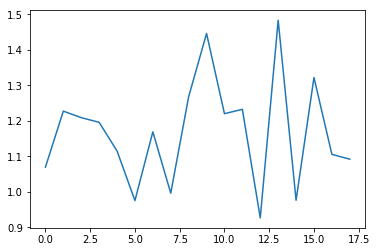

In [698]:
plt.plot(means[1:])

In [ ]:
#Newman-Watts-Strogatz

In [ ]:
n = 10
k = 3
p = .9
# build random graph
nws_G = nx.connected_watts_strogatz_graph(n, k, p)

# make G directed
edges = nws_G.edges()
nws_G = nx.DiGraph(edges)

In [ ]:
nx.draw(nws_G)

In [699]:
# construct a dataframe to store our data
res = 20 # the resolution
df_NWS = pd.DataFrame(columns=range(res-1))
df_NWS

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18


In [700]:
n_iterations = 10
n_nodes = 50
k_connected = 10
p_create_edge = 0.5
for __ in xrange(n_iterations):
    nws_G = nx.connected_watts_strogatz_graph(n=n_nodes, k=k_connected, p=p_create_edge)
    alpha_one = 0
    errors = []
    for alpha in [(1.0/res)*(x+1) for x in range(res-1)]:
        pr_next = nx.pagerank(nws_G, alpha=alpha) # compute new page rank
        
        # compute MSE
        error = mean_squared_error(nws_G, alpha_one, alpha)
        errors.append(error)
        
        alpha_one = alpha # prepare for next iteration
    new_row = pd.Series(errors)
    df_NWS = df_NWS.append(new_row, ignore_index=True)

In [701]:
df_NWS

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,74.883242,1.224745,1.224745,1.414214,1.581139,1.000000,1.224745,1.000000,1.000000,2.645751,0.000000,1.000000,0.707107,0.707107,0.000000,0.707107,0.707107,0.000000,0.707107
1,66.835619,2.000000,1.870829,1.000000,1.224745,1.000000,1.224745,1.224745,1.732051,1.870829,1.000000,1.224745,0.000000,0.707107,0.000000,1.000000,0.000000,1.000000,0.707107
2,69.663477,1.224745,1.870829,1.224745,1.224745,1.000000,1.414214,1.000000,0.707107,0.707107,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.707107,0.000000,0.707107
3,73.474485,1.414214,1.000000,1.224745,1.000000,1.581139,1.000000,1.870829,0.000000,0.707107,0.000000,0.707107,0.707107,1.224745,0.000000,1.224745,0.707107,0.707107,0.000000
4,71.700767,2.000000,1.581139,1.224745,1.000000,1.732051,0.000000,1.000000,1.581139,1.224745,1.000000,0.707107,0.000000,0.707107,1.000000,0.707107,1.000000,0.707107,1.581139
5,66.996269,1.224745,1.414214,1.732051,1.732051,2.345208,1.581139,0.707107,1.581139,1.870829,0.707107,0.000000,0.000000,0.000000,1.224745,0.707107,0.000000,0.707107,1.000000
6,70.039275,2.000000,1.581139,1.000000,2.345208,0.707107,1.414214,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.707107,1.000000
7,71.780917,1.732051,1.414214,2.121320,1.732051,1.870829,2.000000,2.121320,1.870829,1.000000,1.224745,1.224745,0.707107,0.707107,0.000000,0.707107,1.732051,0.707107,0.707107
8,74.719475,1.000000,1.414214,1.224745,1.732051,1.732051,1.581139,1.732051,1.581139,1.414214,1.224745,1.000000,1.000000,1.000000,0.707107,0.707107,0.000000,1.414214,0.707107
9,74.330344,0.707107,1.224745,1.414214,1.581139,1.000000,1.414214,0.707107,0.000000,0.000000,1.000000,0.000000,0.000000,0.707107,0.000000,0.707107,1.000000,0.707107,0.707107


In [702]:
means = []
for col in df_NWS.columns:
    list_data = df_NWS[col]
    mean = np.mean(list_data)
    means.append(mean)

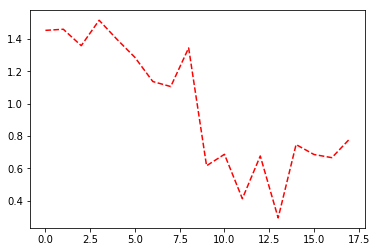

In [703]:
plt.plot(means[1:], 'r--')

In [ ]:
#Internet

In [5]:
# construct a dataframe to store our data
res = 20 # the resolution
df_internet = pd.DataFrame(columns=range(res-1))
df_internet

NameError: name 'pd' is not defined

In [6]:
n_iterations = 10
for __ in xrange(n_iterations):
    alpha_one = 0
    errors = []
    for alpha in [(1.0/res)*(x+1) for x in range(res-1)]:
        pr_next = nx.pagerank(G, alpha=alpha) # compute new page rank
        
        # compute MSE
        error = mean_squared_error(G, alpha_one, alpha) 
        errors.append(error)
        
        alpha_one = alpha # prepare for next iteration
    new_row = pd.Series(errors)
    df_internet = df_internet.append(new_row, ignore_index=True)

NameError: name 'nx' is not defined

In [7]:
df_internet

NameError: name 'df_internet' is not defined

In [ ]:
means = []
for col in df_internet.columns:
    list_data = df_internet[col]
    mean = np.mean(list_data)
    means.append(mean)

In [1]:
plt.plot(means[1:], 'g-.')

NameError: name 'plt' is not defined